# Basics of Survival Analysis and the Kaplan Meier Estimator

### Definitions
- <b>Survival Analysis:</b> a branch of statistics for analyzing the expected duration of time until one event occurs, such as death in biological organisms and failure in mechanical systems (Wikipedia).


- <b>Censoring:</b> a form of missing data problem in which time to event is not observed for reasons such as termination of study before all recruited subjects have shown the event of interest or the subject has left the study prior to experiencing an event. Censoring is common in survival analysis (Wikipedia).


- <b>$T$</b>: a non-negative random variable representing the waiting time until the occurence of an event. $T$ has PDF $f(t)$ and CDF $F(t) = P(T < t)$ (the probability that the event has occured by duration $t$).


- <b>The Survival Function $S(t)$: </b> $S(t) = P(T \geq t) = 1-F(t) = \int_t^{\infty} f(x) dx$


- <b>The Hazard Function $h(t)$:</b> $h(t) = \lim_{dt->0} \frac{P(t \leq  T  \leq T +dt | T \geq t)}{dt} = \frac{f(t)}{S(t)} = \frac{-d}{dt} logS(t)$ (the instantaneous rate of occurence of an event). Note that $S(t) = exp(-\int_0^t h(x) dx)$


- <b>Kaplan-Meier Estimator (Product Limit Estimator):</b> a non-parametric statistic used to estimate the survival function from survival data.

    - $t_i$ - time when at least one event occured
    - $d_i$ - # of events that occured at $t_i$
    - $n_i$ - # of individuals known to have survived (have not yet had an event or been censored) up to $t_i$
    
    - ### $\hat{S}(t) = \prod_{i:t_i \leq t}(1-\frac{d_i}{n_i})$

#### Dependencies

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
%matplotlib inline

#### Kaplan-Meier curve from scratch

In [2]:
def kaplan_meier_curve(duration:np.array, event:np.array):
    
    """
    Get the data needed to plot the Kaplan-Meier Curve
    TODO: add confidence intervals

    Parameters
    ----------
    duration : np.ndarray or list
        An array of times until each individual experienced an event or was censored
        
    event : np.ndarray or list
        An array of boolean values (0 if the individual was censored, 1 if they experienced an event)

    Returns
    -------
    A pandas DataFrame with columns representing the duration and the probability of surviving at least
    to the corresponding duration

    """
    
    if (type(duration) != list) and (type(duration) != np.ndarray):
        
        raise TypeError('Invalid data type for duration')
        
    if (type(event) != list) and (type(event) != np.ndarray):
        
        raise TypeError('Invalid data type for event')
        
    if len(duration) != len(event):
        
        raise ValueError('duration and event must have the same length')
    
    # Convert to dataframe to utilize pandas group by
    data = pd.DataFrame({'duration':duration, 'event':event})
    
    # This will be used to determine the # of individuals at risk at each time
    data['left'] = -1
    
    by_duration = data.groupby('duration').sum().reset_index()
    by_duration.rename({'event':'num_death'}, axis=1, inplace=True)

    start_point = pd.DataFrame({'duration':0, 'num_death':0, 'left':0},index=[0])
    by_duration = pd.concat([start_point, by_duration]).reset_index(drop=True)

    by_duration['total_at_risk'] = by_duration['left'].cumsum().shift(1) + len(data)


    by_duration['hazard'] = by_duration['num_death'] / by_duration['total_at_risk']

    by_duration['non_hazard'] = 1 - by_duration['hazard']

    by_duration['total_at_risk'] = np.where(by_duration['total_at_risk'].isna(), len(data), by_duration['total_at_risk'])
    by_duration['hazard'] = np.where(by_duration['hazard'].isna(), 0, by_duration['hazard'])
    by_duration['non_hazard'] = np.where(by_duration['non_hazard'].isna(), 1, by_duration['non_hazard'])

    by_duration['survival'] = by_duration['non_hazard'].cumprod()

    by_duration = by_duration[(by_duration['num_death'] > 0) | (by_duration['left'] == 0)]

    return by_duration[['duration','survival']]



In [3]:
# Test on fake data
# Each row represents either the time when an individual experienced an event (event = 1) or the time
# when an individual was censored (event = 0)
data = pd.DataFrame({'duration':[2,3,6,6,7,10,15,15,16,27,30,32],
                     'event':[1,0,1,1,1,0,1,1,1,1,1,1]})

data

,duration,event
0,2,1
1,3,0
2,6,1
3,6,1
4,7,1
5,10,0
6,15,1
7,15,1
8,16,1
9,27,1


In [4]:
km_data = kaplan_meier_curve(data['duration'].values, data['event'].values)
km_data

,duration,survival
0,0,1.000000
1,2,0.916667
3,6,0.733333
4,7,0.641667
6,15,0.427778
7,16,0.320833
8,27,0.213889
9,30,0.106944
10,32,0.000000


Text(0.5, 1.0, 'Kaplan Meier Curve')

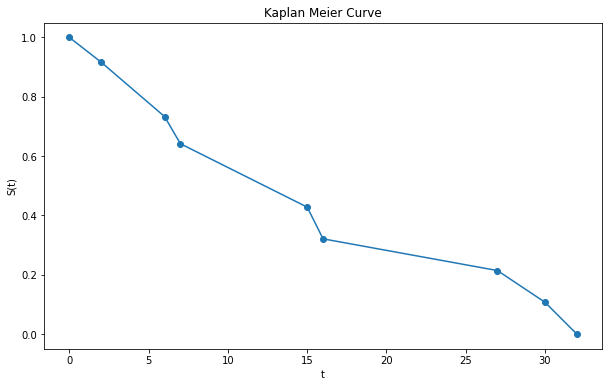

In [5]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(km_data['duration'], km_data['survival'])
ax.plot(km_data['duration'], km_data['survival'])
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
ax.set_title('Kaplan Meier Curve')

#### KM Curve on  a real dataset and compared to lifeline version

In [13]:
data = pd.read_csv('data/lung.csv').drop("Unnamed: 0", axis=1)
print(data.shape)
data.head()

(228, 10)


,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [14]:
# Replace status with 1's and 0's
data['status'].replace({1:0, 2:1}, inplace=True)
data.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


In [15]:
# KM data from our function
km_data = kaplan_meier_curve(data['time'].values, data['status'].values)
km_data

,duration,survival
0,0,1.000000
1,5,0.995614
2,11,0.982456
3,12,0.978070
4,13,0.969298
...,...,...
175,735,0.097894
177,765,0.088105
178,791,0.078315
180,814,0.067127


In [18]:
# KM data from KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(data['time'].values, data['status'].values)
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
5.0,0.995614
11.0,0.982456
12.0,0.978070
13.0,0.969298
...,...
840.0,0.067127
883.0,0.050346
965.0,0.050346


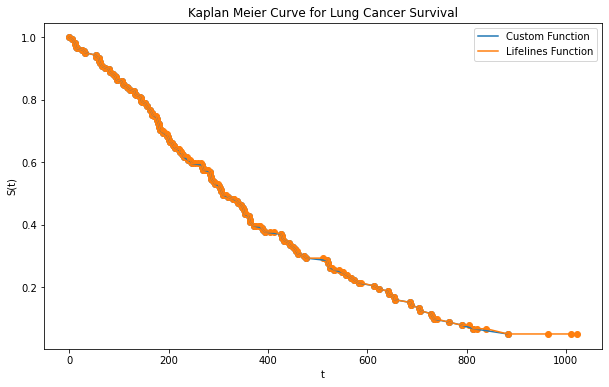

In [21]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(km_data['duration'], km_data['survival'])
ax.plot(km_data['duration'], km_data['survival'], label='Custom Function')
ax.scatter(kmf.survival_function_.index, kmf.survival_function_.KM_estimate)
ax.plot(kmf.survival_function_.index, kmf.survival_function_.KM_estimate, label='Lifelines Function')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
ax.set_title('Kaplan Meier Curve for Lung Cancer Survival')
ax.legend()

<AxesSubplot:xlabel='timeline'>

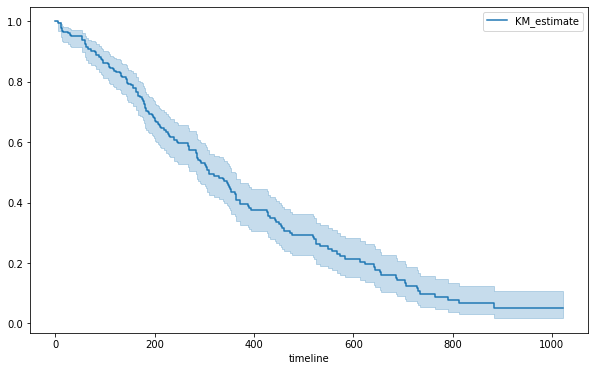

In [23]:
fig,ax = plt.subplots(figsize=(10,6))
kmf.plot()